In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
#Modeling for Hi-C metrix
data="plot/DEGs_final/"

data_generator=ImageDataGenerator(
    validation_split=0.3,
    rescale=1./255)
train_generator =data_generator.flow_from_directory(data,
                                                    subset='training',
                                                    batch_size= 16,
                                                    target_size = (200,200),
                                                    shuffle=True,
                                                    class_mode = 'categorical')
validation_generator =data_generator.flow_from_directory(data,
                                                    subset='validation',
                                                    batch_size= 16,
                                                    target_size = (200,200),
                                                    shuffle=True,
                                                    class_mode = 'categorical')

class_map = {
    0:'resistant',
    1:'sensitive', 
}

#model2
model = Sequential([
                    Conv2D(32, (3,3), padding='same' ,activation= 'relu', input_shape = (200,200,3)),
                    MaxPool2D(2,2),
                    Conv2D(25, (3,3),padding='same', activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(165, (2,2),padding='same', activation='relu'),
                    MaxPool2D(2,2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(1300, activation= 'relu'),
                    Dense(430, activation= 'relu'),
                    Dense(210, activation= 'relu'),
                    Dense(100, activation= 'relu'),
                    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only = True,
                             save_best_only = True,
                             monitor = 'val_loss',
                             verbose=1)
history = model.fit(train_generator,
                    validation_data = (validation_generator),
                    epochs = 20,
                    callbacks = [checkpoint])

# val_loss, val_acc graph
epochs=20
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#visualization
for x, y in validation_generator:
    print(x.shape,y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

In [8]:
#test set confirmation
test="plot/test/"
test_generator=ImageDataGenerator(
    rescale=1./255)
test_set =test_generator.flow_from_directory(test,
                                                   batch_size= 4,
                                                   target_size = (200,200),
                                                   shuffle=True,
                                                   class_mode = 'categorical')

n_img = test_set.n
steps = n_img // 4
import numpy as np

imgs, labels = [], []
for i in range(steps):
    a, b = test_set.next()
    imgs.extend(a)
    labels.extend(b)

imgs = np.asarray(imgs)
labels = np.asarray(labels)

re_model=tf.keras.models.load_model("hic_resistance_model2.h5")
re_model.evaluate(test_set)


Found 40 images belonging to 2 classes.


In [ ]:
'''
#model1
model = Sequential([
                    Conv2D(32, (3,3), padding='same' ,activation= 'relu', input_shape = (200,200,3)),
                    MaxPool2D(2,2),
                    Conv2D(64, (3,3),padding='same', activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(128, (3,3),padding='same', activation='relu'),
                    MaxPool2D(2,2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(1024, activation= 'relu'),
                    Dense(512, activation= 'relu'),
                    Dense(256, activation= 'relu'),
                    Dense(64, activation= 'relu'),
                    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only = True,
                             save_best_only = True,
                             monitor = 'val_loss',
                             verbose=1)
history = model.fit(train_generator,
                    validation_data = (validation_generator),
                    epochs = 20,
                    callbacks = [checkpoint])
'''

In [20]:
#Explain the model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np
import shap

In [21]:
model=tf.keras.models.load_model("hic_resistance_model1.h5")
#model=VGG16()
# load an image
file = "plot/DEGs_final/sensitive/a2780_chm13_deg_chr17_29410000-29420000.txt.png"
file2="plot/DEGs_final/resistant/a2780cis_chm13_deg_chr17_29410000-29420000.txt.png"
img = image.load_img(file, target_size=(200, 200))
img2 = image.load_img(file2, target_size=(200, 200))
img_orig = image.img_to_array(img)
img_orig2 = image.img_to_array(img2)

# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
segments_slic2 = slic(img2, n_segments=50, compactness=30, sigma=3)

In [22]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 200))) 
def g(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic2, img_orig2, 200)))

In [23]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs VGG16 1000 times
explainer2 = shap.KernelExplainer(g, np.zeros((1,50)))
shap_values2 = explainer2.shap_values(np.ones((1,50)), nsamples=1000) # runs VGG16 1000 times

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
preds2 = model.predict(preprocess_input(np.expand_dims(img_orig2.copy(), axis=0)))
top_preds2 = np.argsort(-preds2)

In [25]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)
feature_names = {'1': ['n01440764', 'sensitive'],
 '0': ['n01443537', 'resistance']}

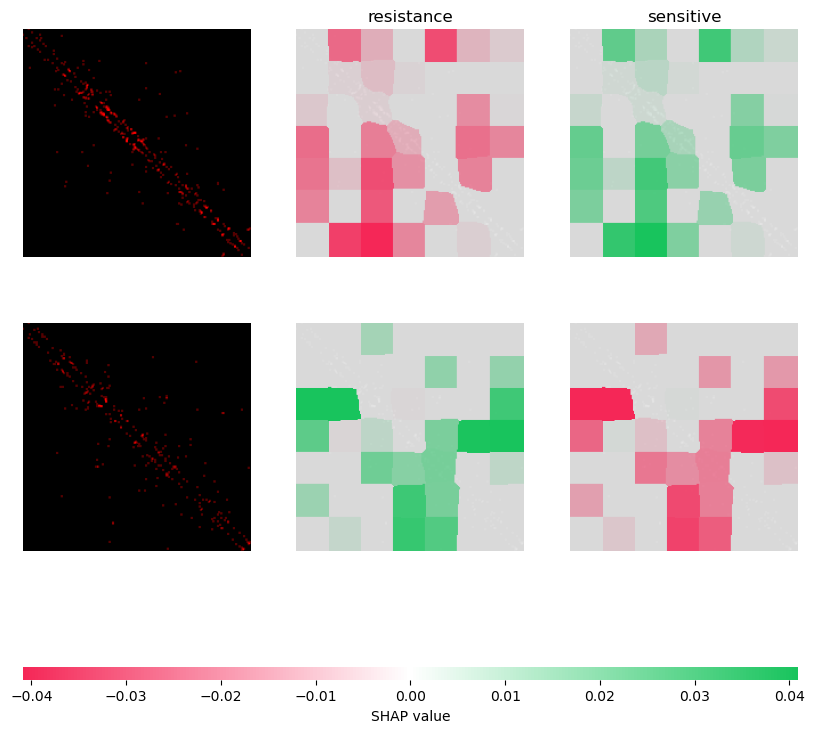

In [26]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations

fig, axes = pl.subplots(nrows=2, ncols=3, figsize=(10,10))
inds = top_preds[0]
inds2 = top_preds2[0]
axes[0,0].imshow(img)
axes[0,0].axis('off')
axes[1,0].imshow(img2)
axes[1,0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    m2 = fill_segmentation(shap_values2[inds2[i]][0], segments_slic2)
    axes[0,i+1].set_title(feature_names[str(inds[i])][1])
    axes[0,i+1].imshow(img.convert('LA'), alpha=0.15)
    axes[1,i+1].imshow(img2.convert('LA'), alpha=0.15)
    im = axes[0,i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[1,i+1].imshow(m2, cmap=cm, vmin=-max_val, vmax=max_val)
    #im = axes[0,i+1].imshow(m, cmap=cm, vmin=-0.1, vmax=0.1)
    #axes[1,i+1].imshow(m2, cmap=cm, vmin=-0.1, vmax=0.1)
    axes[0,i+1].axis('off')
    axes[1,i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False) #Ture로 바꿔보자 
pl.show()